In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import warnings
from sklearn.model_selection import train_test_split
import importlib 
import warnings
import urllib3
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logging

## 1. Create Directories and Load Data

In [2]:
import config
importlib.reload(config)

from config import DatasetConfig

# Create necessary directories
os.makedirs(DatasetConfig.PATHS['results'], exist_ok=True)
os.makedirs('model', exist_ok=True)

# Load the annotations
print("Loading annotations...")
annotations = pd.read_csv(DatasetConfig.PATHS['csv'])
print("Annotations shape:", annotations.shape)

Loading annotations...
Annotations shape: (5758, 2)


## 2. Analyze Dataset

,ground truth
count,5758.000000
mean,0.183050
std,0.386741
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


ground truth
0    4704
1    1054
Name: count, dtype: int64

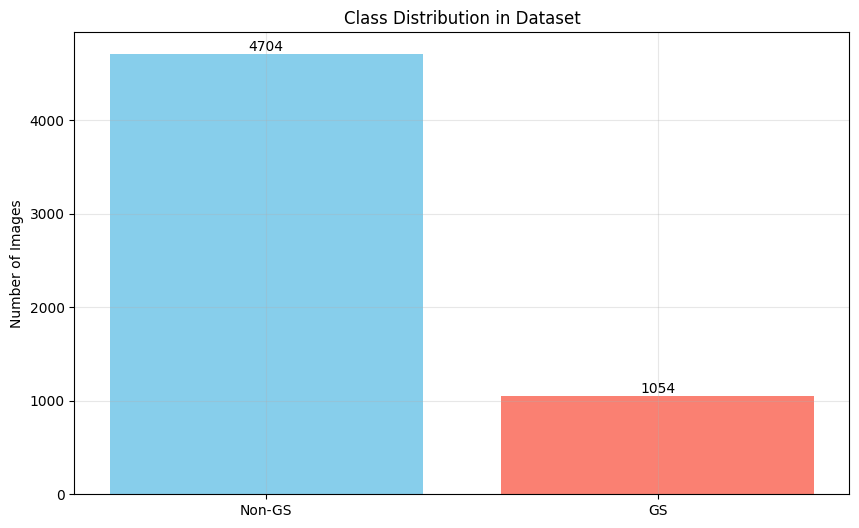

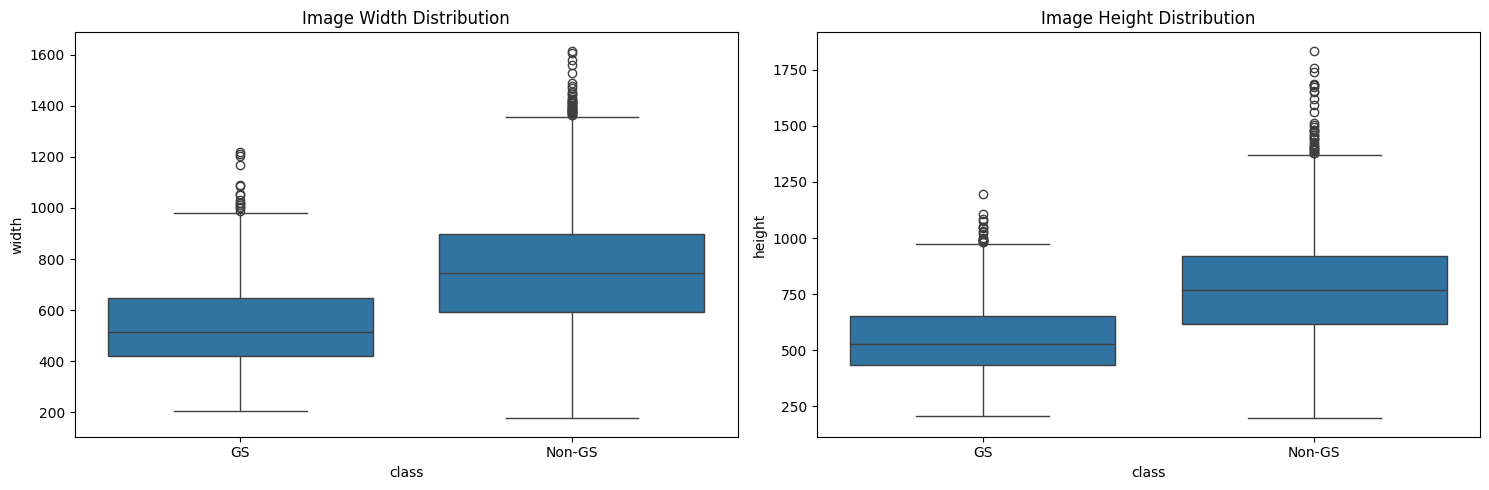

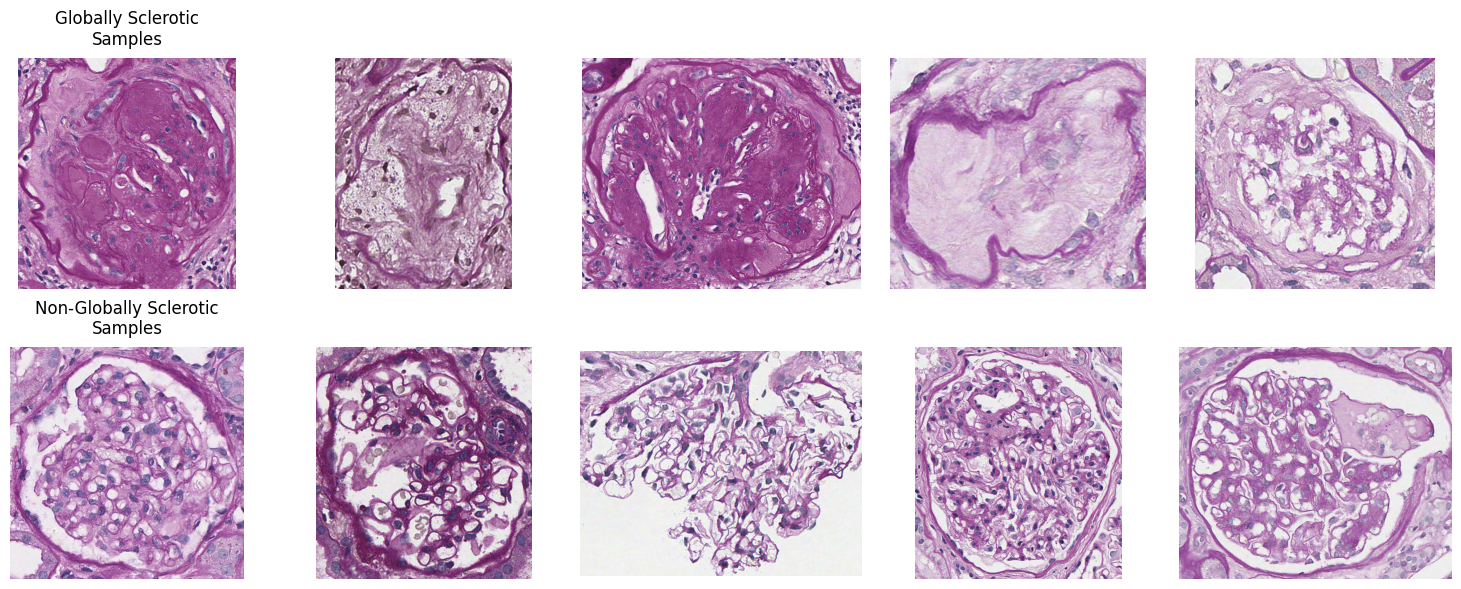

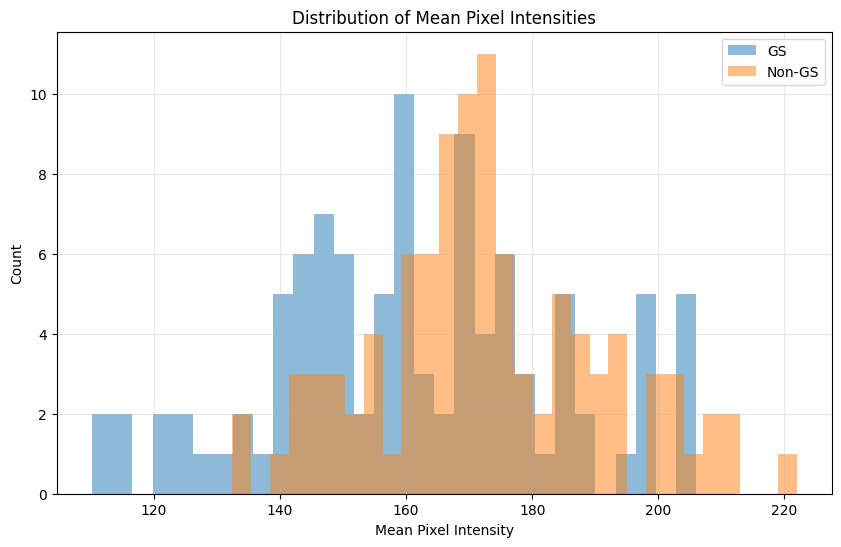

In [3]:
import data_analyzer
importlib.reload(data_analyzer)

from data_analyzer import DataAnalyzer

analyzer = DataAnalyzer(annotations, DatasetConfig.PATHS['results'])
analyzer.analyze_data()

## 3. Split Dataset and Create Data Generators

In [4]:
import data_generator
importlib.reload(data_generator)

from data_generator import GlomeruliDataGenerator

train_val_df, test_df = train_test_split(annotations, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)

print("Dataset splits:")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Dataset splits:
Training samples: 3454
Validation samples: 1152
Test samples: 1152


In [5]:
# Create data generators for each set
train_generator = GlomeruliDataGenerator(
    train_df, 
    DatasetConfig.PATHS['base'],
    batch_size=DatasetConfig.TRAINING['batch_size'],
    image_size=DatasetConfig.TRAINING['image_size']
)

val_generator = GlomeruliDataGenerator(
    val_df,
    DatasetConfig.PATHS['base'],
    batch_size=DatasetConfig.TRAINING['batch_size'],
    image_size=DatasetConfig.TRAINING['image_size'],
    shuffle=False
)

test_generator = GlomeruliDataGenerator(
    test_df,
    DatasetConfig.PATHS['base'],
    batch_size=DatasetConfig.TRAINING['batch_size'],
    image_size=DatasetConfig.TRAINING['image_size'],
    shuffle=False
)

print("Data generators created successfully")

Data generators created successfully


## 4. Create and Compile Model

In [6]:
import resnet_model_builder
importlib.reload(resnet_model_builder)

from resnet_model_builder import ModelBuilder

# Create model with your input shape
model = ModelBuilder.create_model(input_shape=(224, 224, 3))

# Print model summary to verify architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               1

## 5. Train Model

In [7]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import resnet_model_trainer
importlib.reload(resnet_model_trainer)

from resnet_model_trainer import ModelTrainer

# Your training code
model = ModelBuilder.create_model(input_shape=(224, 224, 3))
trainer = ModelTrainer(model, train_generator, val_generator, results_dir=DatasetConfig.PATHS['results'])
history = trainer.train()

Epoch 1/25
108/108 [==============================] - 181s 2s/step - loss: 0.6643 - accuracy: 0.7415 - auc: 0.7970 - val_loss: 0.4269 - val_accuracy: 0.8585 - val_auc: 0.9525 - lr: 1.0000e-04
Epoch 2/25
 74/108 [===================>..........] - ETA: 45s - loss: 0.4982 - accuracy: 0.8205 - auc: 0.8773

## 6. Evaluate Model Performance

In [ ]:
import model_evaluator
importlib.reload(model_evaluator)

from model_evaluator import ModelEvaluator

# Initialize evaluator and perform evaluation
print("Evaluating model performance...")
evaluator = ModelEvaluator(model, test_generator, DatasetConfig.PATHS['results'])
evaluator.evaluate(history)

## 7. Evaluation on New Dataset

In [ ]:
import evaluation
importlib.reload(evaluation)
from evaluation import ModelPredictor

# Define paths
model_path = os.path.join('model', 'best_model.keras')
evaluation_dir = 'path/to/your/image/folder'

# Create predictor and run evaluation
predictor = ModelPredictor(
    model_path=model_path,
    evaluation_dir=evaluation_dir
)
predictor.predict_images()